### Import Libraries

In [50]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### Load the Datasets 

In [51]:
import pandas as pd
import os
import logging

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load features from all methods
def load_all_features(file_paths, num_features=10):
    feature_sets = {}

    # Fold-Change
    if os.path.exists(file_paths["fold_change"]):
        fc_data = pd.read_csv(file_paths["fold_change"])
        feature_sets["fold_change"] = set(fc_data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])

    # Chi-Squared
    if os.path.exists(file_paths["chi_squared"]):
        chi2_data = pd.read_csv(file_paths["chi_squared"])
        feature_sets["chi_squared"] = set(chi2_data.nlargest(num_features, "Score")["Feature"])

    # Information Gain
    if os.path.exists(file_paths["information_gain"]):
        ig_data = pd.read_csv(file_paths["information_gain"])
        feature_sets["information_gain"] = set(ig_data.nlargest(num_features, "Info_Gain_General")["Feature"])

    # LASSO
    if os.path.exists(file_paths["lasso"]):
        lasso_data = pd.read_csv(file_paths["lasso"])
        feature_sets["lasso"] = set(lasso_data.nlargest(num_features, "Coefficient")["Feature"])

    # Merge all selected features (removing duplicates)
    combined_features = set().union(*feature_sets.values())

    logging.info(f"Total unique features selected from all methods: {len(combined_features)}")

    return list(combined_features)

# Load processed data
processed_data = pd.read_csv(file_paths["processed_data"])

# Select top features from all methods
num_features_to_select = 10  # Change as needed
top_features = load_all_features(file_paths, num_features=num_features_to_select)

2025-01-31 08:47:31,899 - INFO - Total unique features selected from all methods: 39


### Prepare the Data

In [52]:
def process_features_and_labels(processed_data, selected_features, target_column="stage"):
    """
    Filter processed data for selected features and extract target labels.

    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.
        target_column (str): Name of the target column.

    Returns:
        tuple: Filtered features (pd.DataFrame) and target labels (pd.Series).
    """
    # Verify all selected features exist in the data
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"⚠️ {len(missing_features)} features missing from dataset! Missing features: {missing_features}")
    
    # Stop if too many features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:  # More than 50% missing
        raise ValueError(f"🚨 More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Filter processed data
    expression_values = processed_data[selected_features]
    y = processed_data[target_column]

    # Ensure all features are numeric
    expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

    # Check for missing values
    if expression_values.isnull().values.any() or y.isnull().values.any():
        logging.warning("⚠️ Missing values detected in features or labels.")
        print(f"\n🔍 Missing values per feature (top 5 with missing values):")
        missing_counts = expression_values.isnull().sum()
        print(missing_counts[missing_counts > 0].head())
        print(f"\n🔍 Missing values in labels: {y.isnull().sum()}")

        # Drop rows with missing values
        valid_indices = ~(expression_values.isnull().any(axis=1) | y.isnull())
        expression_values = expression_values[valid_indices]
        y = y[valid_indices]

    # Log data info
    logging.info(f"Features shape: {expression_values.shape}")
    logging.info(f"Labels shape: {y.shape}")
    logging.info(f"Class distribution:\n{y.value_counts(normalize=True)}")

    # Data quality checks
    if len(y.unique()) < 2:
        raise ValueError("🚨 Less than 2 classes present in labels after preprocessing!")

    if expression_values.shape[0] < 10:
        logging.warning("⚠️ Very few samples remaining after preprocessing!")

    return expression_values, y

# Process features and labels
expression_values, y = process_features_and_labels(processed_data, top_features, target_column="stage")

# ✅ Debugging: Check the prepared data
print("\nExpression values sample:")
print(expression_values.head())

print("\nFeature statistics:")
print(expression_values.describe())

print("\n📌 Target variable distribution:")
print(y.value_counts())

print("\n📌 Class proportions:")
print(y.value_counts(normalize=True))

2025-01-31 08:47:34,615 - INFO - Features shape: (1091, 39)
2025-01-31 08:47:34,616 - INFO - Labels shape: (1091,)
2025-01-31 08:47:34,618 - INFO - Class distribution:
stage
1    0.518790
2    0.282310
3    0.160403
4    0.028414
0    0.010082
Name: proportion, dtype: float64



Expression values sample:
   hsa-mir-8082  hsa-mir-631  hsa-mir-519d  hsa-mir-4637  hsa-mir-515-2  \
0           0.0          0.0      0.000000           0.0       0.000000   
1           0.0          0.0      0.153599           0.0       0.153599   
2           0.0          0.0      0.000000           0.0       0.000000   
3           0.0          0.0      0.000000           0.0       0.000000   
4           0.0          0.0      0.000000           0.0       0.000000   

   hsa-mir-203b  hsa-mir-1181  hsa-mir-524  hsa-mir-509-1  hsa-mir-451b  ...  \
0     33.918210      0.000000     0.000000       0.335824           0.0  ...   
1     44.389989      0.153599     0.000000       3.532767           0.0  ...   
2    131.575653      0.000000     0.000000       4.075352           0.0  ...   
3      8.416028      0.280534     0.280534       1.683206           0.0  ...   
4     76.138425      0.460051     0.000000       0.460051           0.0  ...   

   hsa-mir-3973  hsa-mir-4300  hsa-mir-39

### SMOTE & Train-Test Split

In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\n")
print("Initial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

top_features = [feature for feature in top_features if feature in processed_data.columns]
if not top_features:
    raise ValueError("🚨 No matching features found in processed data for the selected feature set!")

# Filter and Prepare Data
expression_values = processed_data[top_features]
y = processed_data["stage"]

print("\n")
print("Data shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)
print("Target labels shape:", y.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1) | y.isnull())  # Keep aligned
expression_values = expression_values[valid_indices]
y = y[valid_indices]

print("\n")
print("Data shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)
print("Target labels shape:", y.shape)

# Check for class imbalance before applying SMOTE
print("\n")
print("Class distribution before SMOTE:")
print(y.value_counts())

# Apply SMOTE only if imbalance is detected
class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

if imbalance_ratio > 1.5:  # Arbitrary threshold: Apply SMOTE if the largest class is >1.5x the smallest class
    print("\n")
    print("Imbalance detected. Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(expression_values, y)
else:
    print("\n")
    print("No major imbalance detected. Skipping SMOTE.")
    X_resampled, y_resampled = expression_values, y  # Keep the original data

# Scale features AFTER SMOTE
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Log Split Information
print("\n")
print("Train-Test Split Information:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

print("\n")
print("Training set class distribution:")
print(pd.Series(y_train).value_counts())

print("\n")
print("Testing set class distribution:")
print(pd.Series(y_test).value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features}



Initial data check:
Top features: ['hsa-mir-8082', 'hsa-mir-631', 'hsa-mir-519d', 'hsa-mir-4637', 'hsa-mir-515-2', 'hsa-mir-203b', 'hsa-mir-1181', 'hsa-mir-524', 'hsa-mir-509-1', 'hsa-mir-451b', 'hsa-mir-520e', 'hsa-mir-760', 'hsa-mir-187', 'hsa-mir-523', 'hsa-mir-1825', 'hsa-mir-520h', 'hsa-mir-6766', 'stage', 'hsa-mir-520d', 'subtype', 'hsa-mir-1253', 'hsa-mir-185', 'hsa-mir-1283-2', 'hsa-mir-518f', 'hsa-mir-4257', 'hsa-mir-5690', 'hsa-mir-571', 'hsa-mir-548ak', 'hsa-mir-526a-2', 'hsa-mir-3973', 'hsa-mir-4300', 'hsa-mir-3922', 'hsa-mir-4731', 'hsa-mir-5583-1', 'hsa-mir-3661', 'hsa-mir-6071', 'hsa-mir-8066', 'hsa-mir-181d', 'hsa-mir-4663']
Number of top features: 39


Data shapes before handling missing values:
Expression values shape: (1091, 39)
Target labels shape: (1091,)


Data shapes after handling missing values:
Expression values shape: (1091, 39)
Target labels shape: (1091,)


Class distribution before SMOTE:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dt

### Train the SVM Classifier

In [54]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Perform Grid Search
svm = SVC(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train and Evaluate Model
best_svm = grid_search.best_estimator_
y_pred = best_svm.fit(X_train, y_train).predict(X_test)

# Display Results
print("\n")
print("Best SVM Hyperparameters:", grid_search.best_params_)
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))



Best SVM Hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       0.99      0.99      0.99       113
           2       0.99      0.98      0.99       113
           3       0.99      1.00      1.00       114
           4       1.00      1.00      1.00       113

    accuracy                           0.99       566
   macro avg       0.99      0.99      0.99       566
weighted avg       0.99      0.99      0.99       566



### Evaluate the Model


-------------------- SVM Results --------------------

 Accuracy: 0.9947

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       0.99      0.99      0.99       113
           2       0.99      0.98      0.99       113
           3       0.99      1.00      1.00       114
           4       1.00      1.00      1.00       113

    accuracy                           0.99       566
   macro avg       0.99      0.99      0.99       566
weighted avg       0.99      0.99      0.99       566


 Confusion Matrix:
[[113   0   0   0   0]
 [  0 112   1   0   0]
 [  0   1 111   1   0]
 [  0   0   0 114   0]
 [  0   0   0   0 113]]

 Per-class Accuracy:
Class 0: 1.0000
Class 1: 0.9912
Class 2: 0.9823
Class 3: 1.0000
Class 4: 1.0000


2025-01-31 08:47:59,468 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-31 08:47:59,470 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



 Plot saved as ../results/svm/svm_evaluation_results.png


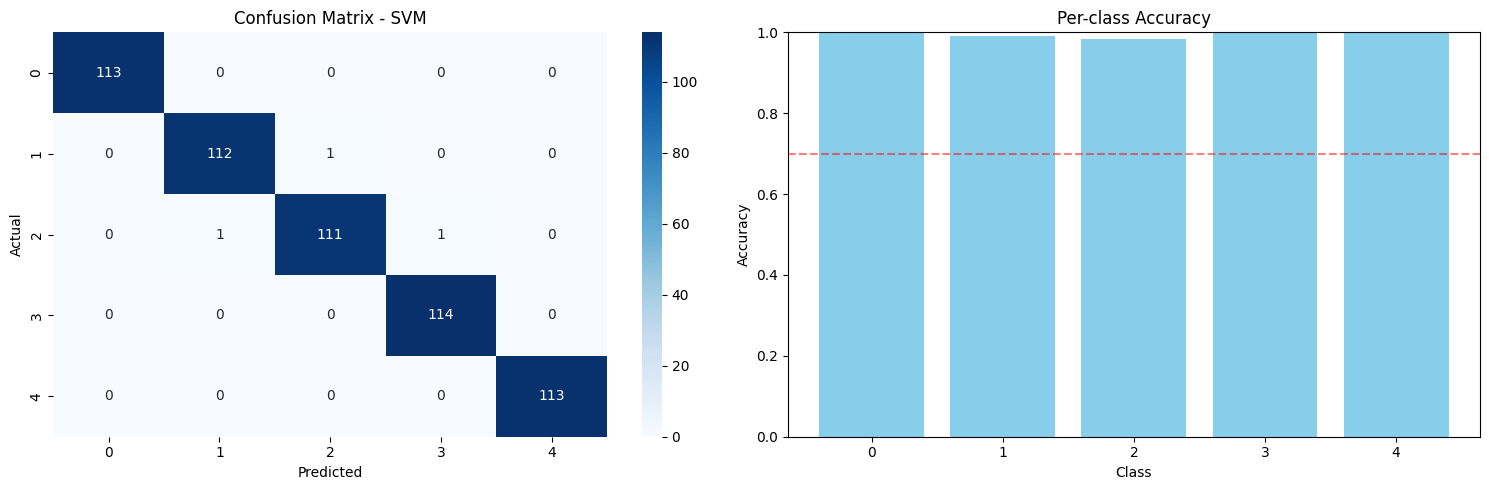

2025-01-31 08:47:59,914 - INFO - 
 Model Evaluation Completed! 
2025-01-31 08:47:59,914 - INFO -  Overall Accuracy: 0.9947
2025-01-31 08:47:59,915 - INFO -  Per-Class Accuracy: [1.0, 0.9911504424778761, 0.9823008849557522, 1.0, 1.0]
2025-01-31 08:47:59,915 - INFO -  Confusion Matrix: [[113, 0, 0, 0, 0], [0, 112, 1, 0, 0], [0, 1, 111, 1, 0], [0, 0, 0, 114, 0], [0, 0, 0, 0, 113]]


In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

def evaluate_model(y_test, y_pred, model_name="SVM", save_path="../results/svm/svm_evaluation_results.png"):
    """
    Evaluate model performance with multiple metrics and visualizations.
    """
    # Ensure Save Directory Exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Determine class labels
    target_names = [str(cls) for cls in sorted(set(y_test))]
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Fix: Avoid Division by Zero in Per-Class Accuracy Calculation
    per_class_accuracy = np.divide(cm.diagonal(), cm.sum(axis=1), where=cm.sum(axis=1) != 0)
    
    # Print results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\n Accuracy: {accuracy:.4f}")
    
    print("\n Classification Report:")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    
    print("\n Confusion Matrix:")
    print(cm)
    
    print("\n Per-class Accuracy:")
    for class_name, acc in zip(target_names, per_class_accuracy):
        print(f"Class {class_name}: {acc:.4f}")
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix Heatmap
    plt.subplot(121)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Per-class Accuracy Bar Plot
    plt.subplot(122)
    colors = ['skyblue' if acc >= 0.7 else 'lightcoral' for acc in per_class_accuracy]
    plt.bar(target_names, per_class_accuracy, color=colors)
    plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.5)  # Threshold line
    plt.ylim(0, 1)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-class Accuracy')
    
    plt.tight_layout()

    #  Save the plot safely
    plt.savefig(save_path)
    print(f"\n Plot saved as {save_path}")

    plt.show()
    
    #  Return Metrics for Logging
    metrics = {
        'accuracy': accuracy,
        'confusion_matrix': cm.tolist(),  # Convert to list for JSON logging
        'classification_report': report,
        'per_class_accuracy': per_class_accuracy.tolist()
    }
    
    return metrics

#  Fixed Usage: Standard Save Path
save_path = "../results/svm/svm_evaluation_results.png"
metrics = evaluate_model(y_test, y_pred, model_name="SVM", save_path=save_path)

#  Improved Logging
logging.info(f"\n Model Evaluation Completed! ")
logging.info(f" Overall Accuracy: {metrics['accuracy']:.4f}")
logging.info(f" Per-Class Accuracy: {metrics['per_class_accuracy']}")
logging.info(f" Confusion Matrix: {metrics['confusion_matrix']}")


### Metrics


📌 Plotting Confusion Matrix:
 Confusion matrix saved to ../results/svm/plots/confusion_matrix.png


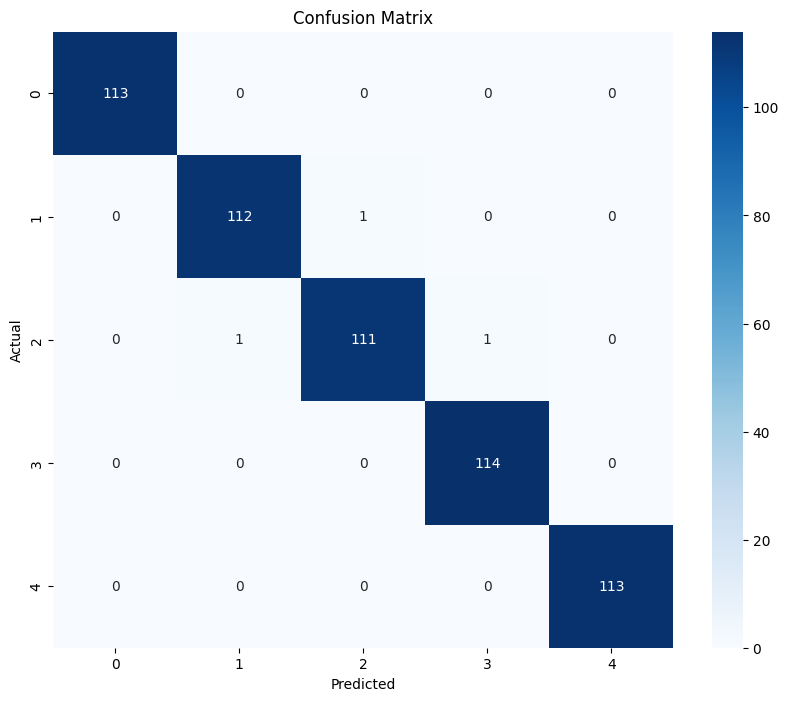


📌 Plotting Metrics Comparison:
 Metrics comparison saved to ../results/svm/plots/metrics_comparison.png


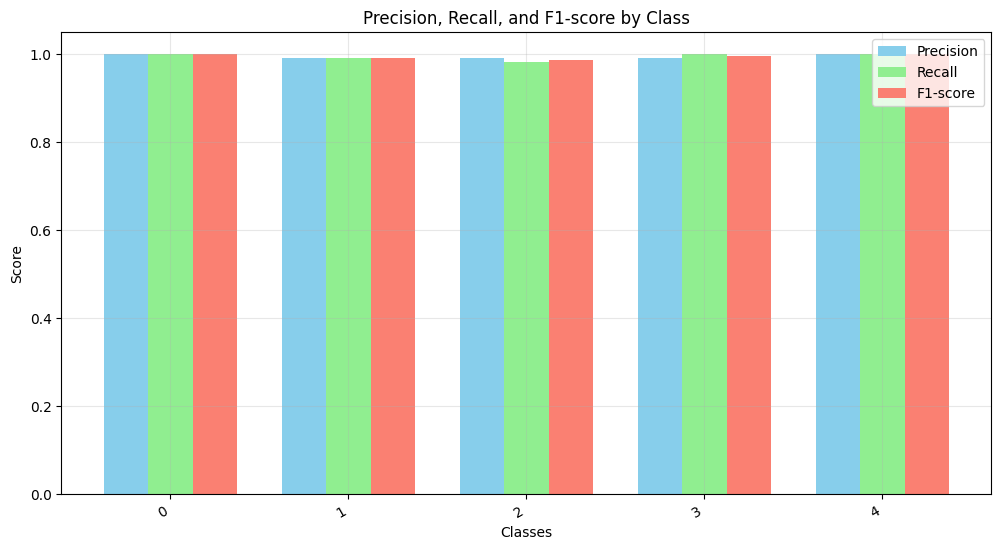


📌 Plotting Metrics Heatmap:
 Metrics heatmap saved to ../results/svm/plots/metrics_heatmap.png


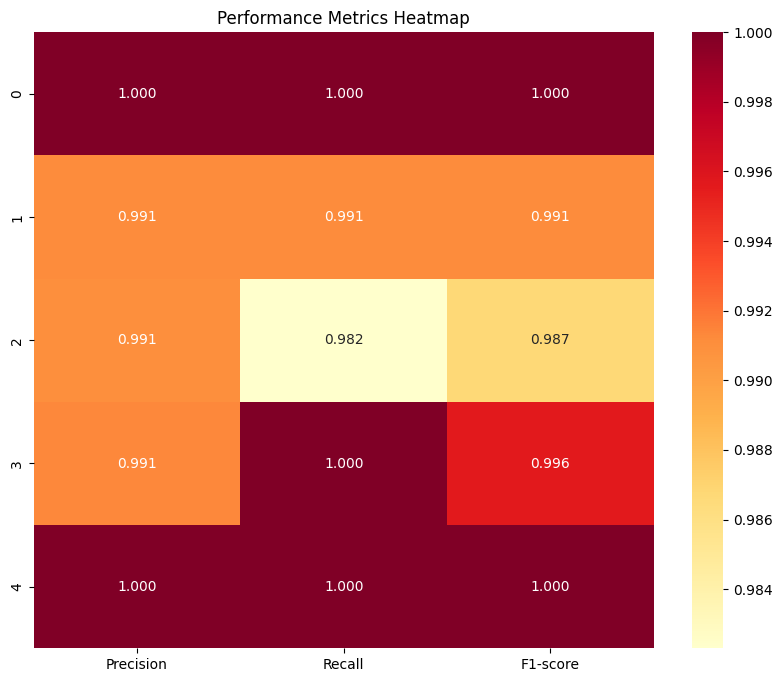

In [56]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#  Fix: Use a single directory for all plots (no method separation)
save_dir = "../results/svm/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_confusion_matrix(y_test, y_pred, target_names, save_path=None):
    """Plot confusion matrix heatmap and save it"""
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(save_path)
        print(f" Confusion matrix saved to {save_path}")
    plt.show()

def plot_metrics_comparison(y_test, y_pred, target_names, save_path=None):
    """Plot precision, recall, and F1-score comparison"""
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    if 'accuracy' in report:
        del report['accuracy']  # Remove overall accuracy entry
    
    # Extract precision, recall, and F1-score
    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for class_name in target_names:
        metrics_data['Precision'].append(report[class_name]['precision'])
        metrics_data['Recall'].append(report[class_name]['recall'])
        metrics_data['F1-score'].append(report[class_name]['f1-score'])
    
    # Plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(target_names))
    width = 0.25
    
    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')
    
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score by Class')
    plt.xticks(x, target_names, rotation=30, ha='right')  #  Slightly rotated labels for better readability
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
        print(f" Metrics comparison saved to {save_path}")
    plt.show()

def plot_metrics_heatmap(y_test, y_pred, target_names, save_path=None):
    """Plot heatmap of metrics for each class"""
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    if 'accuracy' in report:
        del report['accuracy']  # Remove overall accuracy entry
    
    metrics_df = np.array([
        [report[class_name]['precision'], report[class_name]['recall'], report[class_name]['f1-score']]
        for class_name in target_names
    ])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', 
                xticklabels=['Precision', 'Recall', 'F1-score'], 
                yticklabels=target_names, cmap='YlOrRd')
    plt.title('Performance Metrics Heatmap')
    
    if save_path:
        plt.savefig(save_path)
        print(f" Metrics heatmap saved to {save_path}")
    plt.show()

#  Run evaluations and save plots
target_names = [str(cls) for cls in sorted(set(y_test))]

print("\n📌 Plotting Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "confusion_matrix.png"))

print("\n📌 Plotting Metrics Comparison:")
plot_metrics_comparison(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "metrics_comparison.png"))

print("\n📌 Plotting Metrics Heatmap:")
plot_metrics_heatmap(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "metrics_heatmap.png"))


### Save Results

In [57]:
import os
import json
import pandas as pd
import logging
import joblib
from sklearn.metrics import accuracy_score

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define Unified Output Directory (No More Per-Method Separation)
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Convert Labels to Pandas Series for Consistency
y_test = pd.Series(y_test)
y_pred = pd.Series(y_pred)

# Function to Save Predictions
def save_results(y_test, y_pred, output_dir):
    """
    Save predictions and actual labels to a CSV file.
    """
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    output_path = os.path.join(output_dir, 'svm_results.csv')

    try:
        results.to_csv(output_path, index=False)
        logging.info(f"Results saved successfully to {output_path}")
        print(f" Results saved to {output_path}")
    except Exception as e:
        logging.error(f" Failed to save results: {e}")
        print(f" Error: {e}")

# Function to Save Experiment Metadata
def save_metadata(metadata, output_dir):
    """
    Save experiment metadata to a JSON file.
    """
    metadata_path = os.path.join(output_dir, 'svm_metadata.json')
    
    try:
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
            logging.info(f"Metadata saved successfully to {metadata_path}")
            print(f" Metadata saved to {metadata_path}")
    except Exception as e:
        logging.error(f" Failed to save metadata: {e}")
        print(f" Error: {e}")

# Function to Save the Trained Model
def save_model(model, output_dir):
    """
    Save the trained SVM model as a .pkl file.
    """
    model_path = os.path.join(output_dir, 'svm_model.pkl')
    
    try:
        joblib.dump(model, model_path)
        logging.info(f"Model saved successfully to {model_path}")
        print(f" Model saved to {model_path}")
    except Exception as e:
        logging.error(f" Failed to save model: {e}")
        print(f" Error: {e}")

# 🔹 Call Functions to Save Results, Metadata, and Model
save_results(y_test, y_pred, output_dir)

# 🔹 Construct Experiment Metadata
metadata = {
    'Training Set Size': X_train.shape[0],
    'Test Set Size': X_test.shape[0],
    'Kernel': getattr(best_svm, 'kernel', 'Unknown'),
    'Class Weights': getattr(best_svm, 'class_weight', 'Unknown'),
    'Accuracy': round(accuracy_score(y_test, y_pred), 4)
}

save_metadata(metadata, output_dir)
save_model(best_svm, output_dir)  # Save best SVM model

2025-01-31 08:48:18,413 - INFO - Results saved successfully to ../results/svm/svm_results.csv
2025-01-31 08:48:18,416 - INFO - Metadata saved successfully to ../results/svm/svm_metadata.json
2025-01-31 08:48:18,419 - INFO - Model saved successfully to ../results/svm/svm_model.pkl


 Results saved to ../results/svm/svm_results.csv
 Metadata saved to ../results/svm/svm_metadata.json
 Model saved to ../results/svm/svm_model.pkl
